# Setting

In [3]:
import pandas as pd
import torch
import random
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np

from perceiver import tokenize_data, CustomDataset, PerceiverBlock, Perceiver, CombinedModel

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ["Opinion", "Art & Design", "Television"],
    ["Music", "Travel", "Real Estate"],
    ["Books", "Theater", "Health"],
    ["Sports", "Science", "Food"],
    ["Fashion & Style", "Movies", "Technology"],
    ["Dance", "Media", "Style"]
]

output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/youlee/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

print("생성된 그룹별 CSV 파일 경로:")
for path in output_paths:
    print(path)

생성된 그룹별 CSV 파일 경로:
/home/youlee/n24news/n24news/regroup_1.csv
/home/youlee/n24news/n24news/regroup_2.csv
/home/youlee/n24news/n24news/regroup_3.csv
/home/youlee/n24news/n24news/regroup_4.csv
/home/youlee/n24news/n24news/regroup_5.csv
/home/youlee/n24news/n24news/regroup_6.csv


In [2]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
seed_everything(42)

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

In [4]:
def tokenize_data(df, tokenizer=BertTokenizer.from_pretrained('bert-base-uncased'), MAX_LENGTH=128):
    input_ids, attention_masks = [], []
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)

class CustomDataset(Dataset):
    """
    텍스트 전용. Dict 형태(batch['input_ids'], batch['labels'] 등)로 반환
    """
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

class PerceiverBlock(nn.Module):
    """
    - Cross Attention (latents -> x)
    - Self Attention (latent들 끼리)
    - Residual, LayerNorm, MLP(FeedForward) 등 포함
    """
    def __init__(self, latent_dim, n_heads=8, self_attn_layers=1):
        super().__init__()
        # Cross Attention
        self.cross_attn = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=n_heads)
        self.cross_ln = nn.LayerNorm(latent_dim)

        # Self Attention 여러 층
        self.self_attn_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=latent_dim, nhead=n_heads)
            for _ in range(self_attn_layers)
        ])

    def forward(self, latents, x):
        # latents, x: (T, B, dim) 형태
        # 1) Cross Attention
        updated_latents, _ = self.cross_attn(latents, x, x)
        latents = latents + updated_latents
        latents = self.cross_ln(latents)

        # 2) Self Attention 반복
        for layer in self.self_attn_layers:
            latents = layer(latents)  # 내부적으로 Residual/LayerNorm 처리

        return latents

class Perceiver(nn.Module):
    """
    - input_projection: (F -> latent_dim)
    - latents (latent_size, latent_dim): learnable
    - 여러 PerceiverBlock 반복
    - output_layer: (latent_dim -> num_classes)

    x: (B, T, F)
    """
    def __init__(self, input_dim, latent_dim, latent_size, num_classes,
                 num_blocks, self_attn_layers_per_block=1):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(latent_size, latent_dim))
        self.input_projection = nn.Linear(input_dim, latent_dim)

        self.blocks = nn.ModuleList([
            PerceiverBlock(
                latent_dim=latent_dim,
                n_heads=8,
                self_attn_layers=self_attn_layers_per_block
            )
            for _ in range(num_blocks)
        ])

        self.output_layer = nn.Linear(latent_dim, num_classes)

    def forward_to_latent(self, x):
        """
        Perceiver의 최종 분류 레이어 전, (B, latent_dim) 형태의 임베딩만 반환
        """
        B, T, F = x.size()
        # 1) input projection
        x = self.input_projection(x)  # (B, T, latent_dim)

        # latents 초기화 -> (B, latent_size, latent_dim)
        latents = self.latents.unsqueeze(0).expand(B, -1, -1)

        # MultiHeadAttention 호환 위해 (T, B, latent_dim)
        x = x.permute(1, 0, 2)
        latents = latents.permute(1, 0, 2)

        # PerceiverBlock 반복
        for block in self.blocks:
            latents = block(latents, x)

        # (latent_size, B, latent_dim) -> (B, latent_dim)
        latents = latents.permute(1, 0, 2).mean(dim=1)
        return latents

    def forward(self, x):
        """
        (B, T, F) -> 최종 (B, num_classes)
        """
        latents = self.forward_to_latent(x)  # (B, latent_dim)
        return self.output_layer(latents)

class CombinedModel(nn.Module):
    """
    - BERT 임베딩(Embedding) 대신, torch.nn.Embedding + Perceiver
    - forward: (B, T) -> (B, num_classes)
    - get_text_latent: (B, T) -> (B, latent_dim)
    """
    def __init__(self, vocab_size, embed_dim, perceiver_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.perceiver = perceiver_model  # 수정된 Perceiver

    def forward(self, input_ids):
        # (B, T) -> (B, T, embed_dim)
        embeddings = self.embedding(input_ids)
        # (B, T, embed_dim) -> Perceiver -> (B, num_classes)
        return self.perceiver(embeddings)

    def get_text_latent(self, input_ids):
        # 임베딩만 해서 (B, T, embed_dim), Perceiver -> (B, latent_dim)
        embeddings = self.embedding(input_ids)
        return self.perceiver.forward_to_latent(embeddings)


# Functions

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)  
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)  # CombinedModel의 forward 호출
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)  
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [6]:
model_path = '/home/youlee/perceiver/perceiver/model'
loader_path = '/home/youlee/perceiver/perceiver/loader'

In [ ]:
for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)
    sample = dataset [0]
    print(sample)
    print(len(dataset)) 

    dataloader = DataLoader(dataset, batch_size=2, shuffle=False)
    first_batch = next(iter(dataloader))
    print(first_batch)
 

# Train 시작

    epoch 15/15: train loss: 0.0039, train acc: 0.9995
                               test loss: 0.8860, test acc: 0.8432

  fold 4/5 처리 중...
    epoch 1/15: train loss: 0.8957, train acc: 0.5481
                               test loss: 0.6834, test acc: 0.7082
    epoch 5/15: train loss: 0.2199, train acc: 0.9253
                               test loss: 0.4330, test acc: 0.8488
    epoch 10/15: train loss: 0.0436, train acc: 0.9878
                               test loss: 0.7827, test acc: 0.8348
    epoch 15/15: train loss: 0.0104, train acc: 0.9983
                               test loss: 0.9161, test acc: 0.8314

  fold 5/5 처리 중...
    epoch 1/15: train loss: 0.9612, train acc: 0.4937
                               test loss: 0.6442, test acc: 0.7530
    epoch 5/15: train loss: 0.1799, train acc: 0.9396
                               test loss: 0.4966, test acc: 0.8383
    epoch 10/15: train loss: 0.0254, train acc: 0.9935
                               test loss: 0.7991, test 

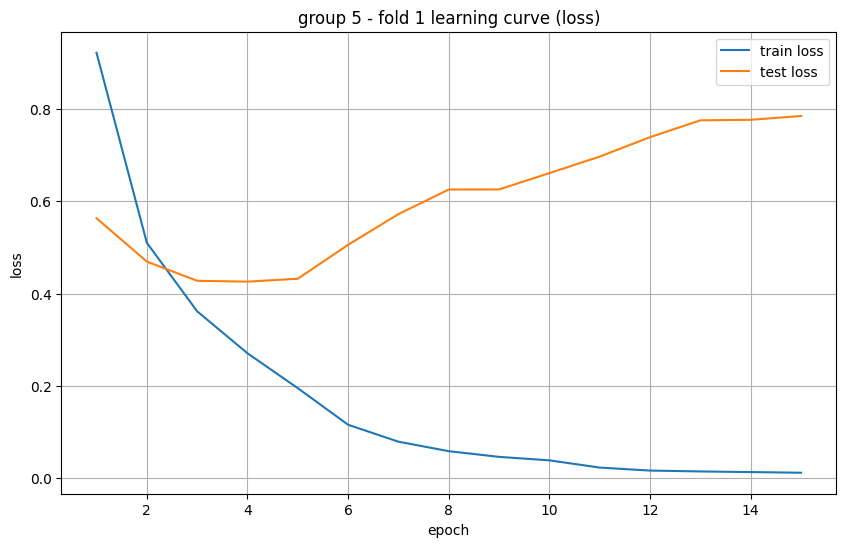

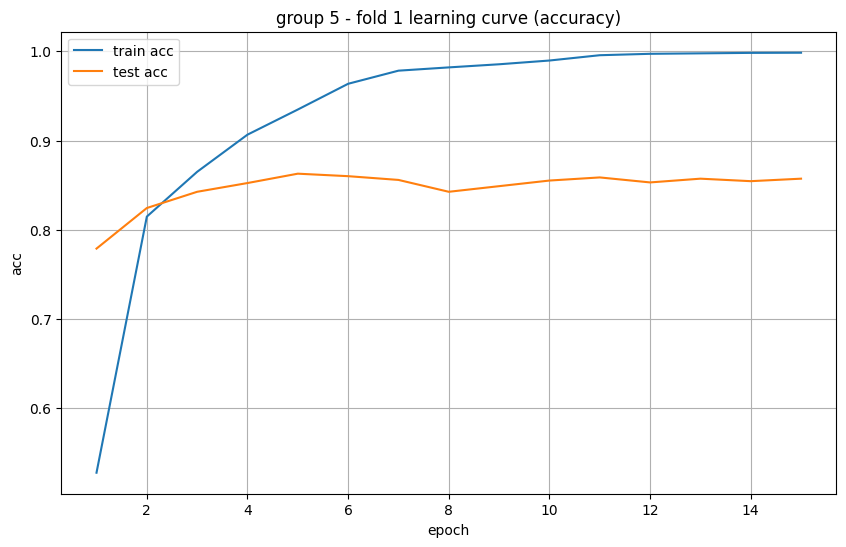

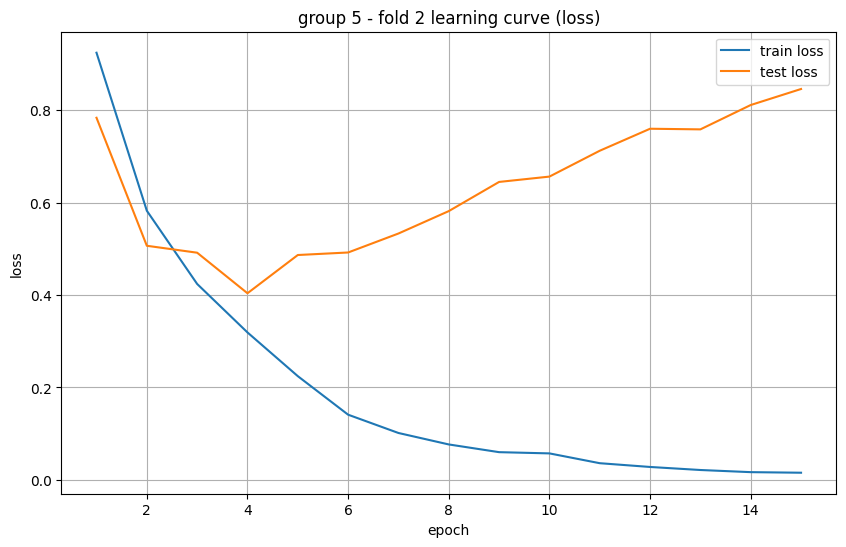

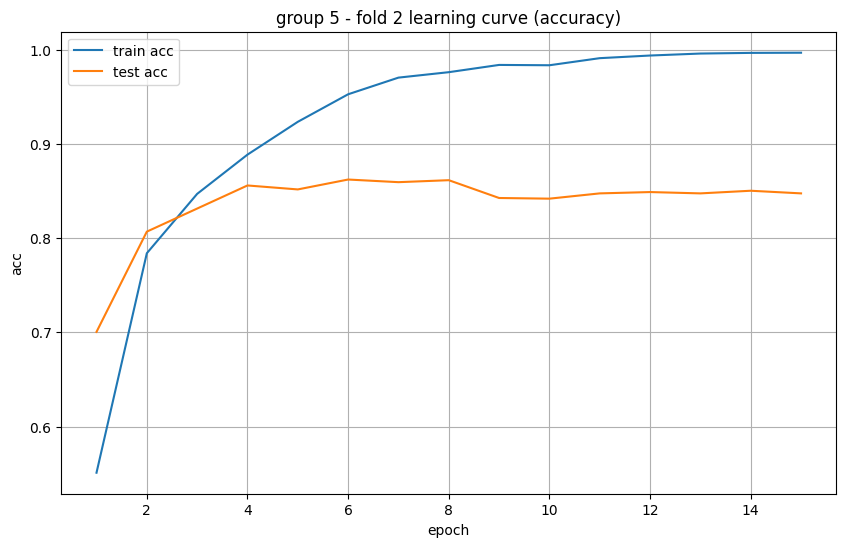

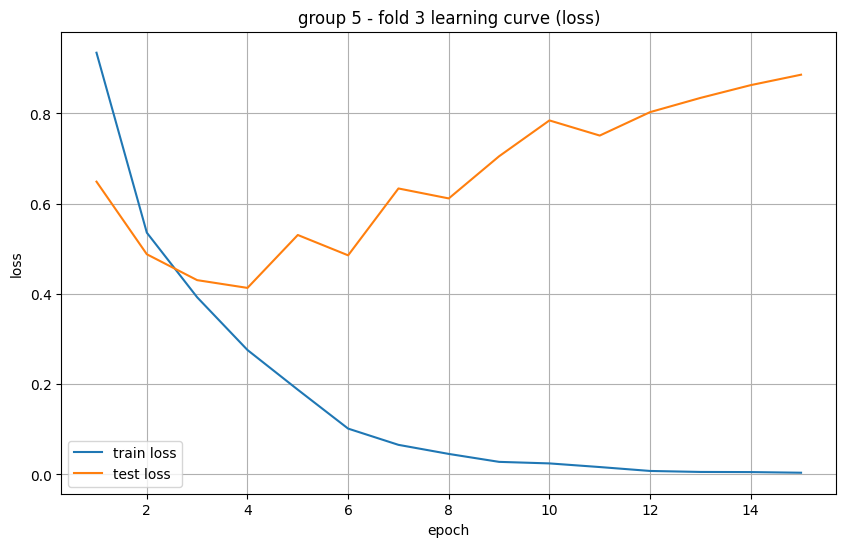

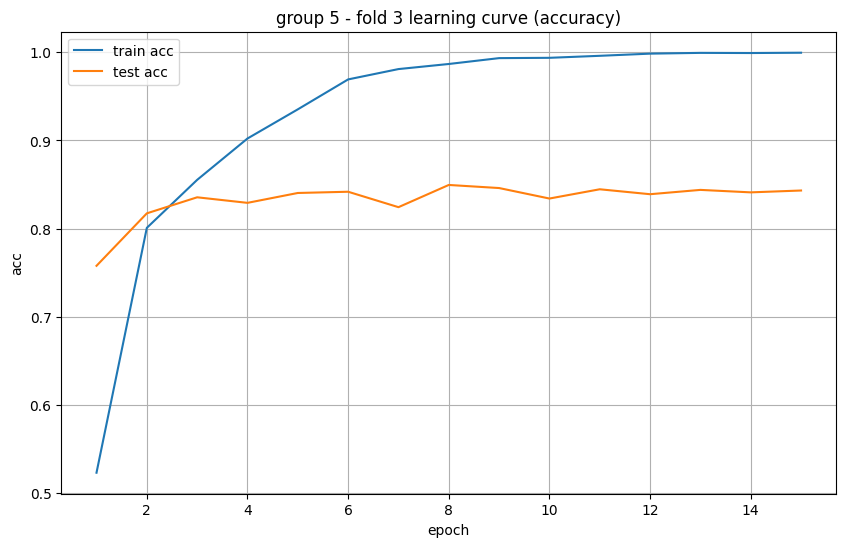

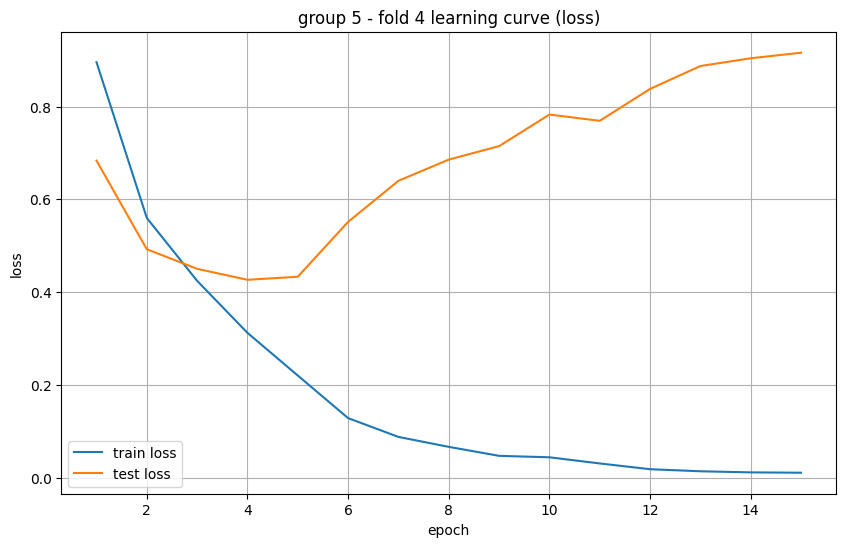

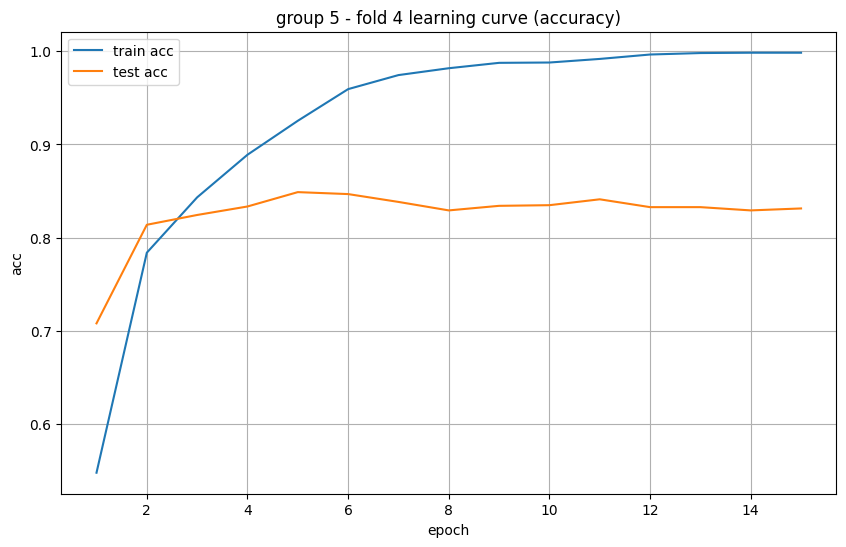

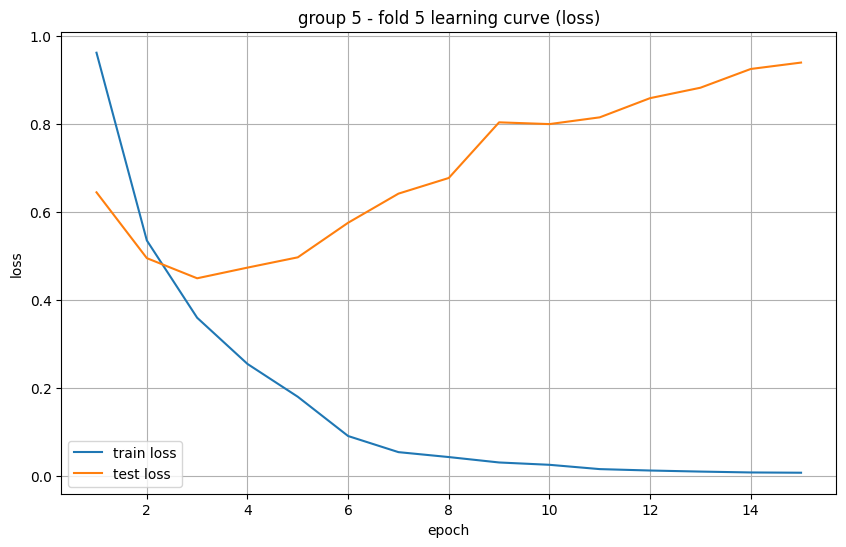

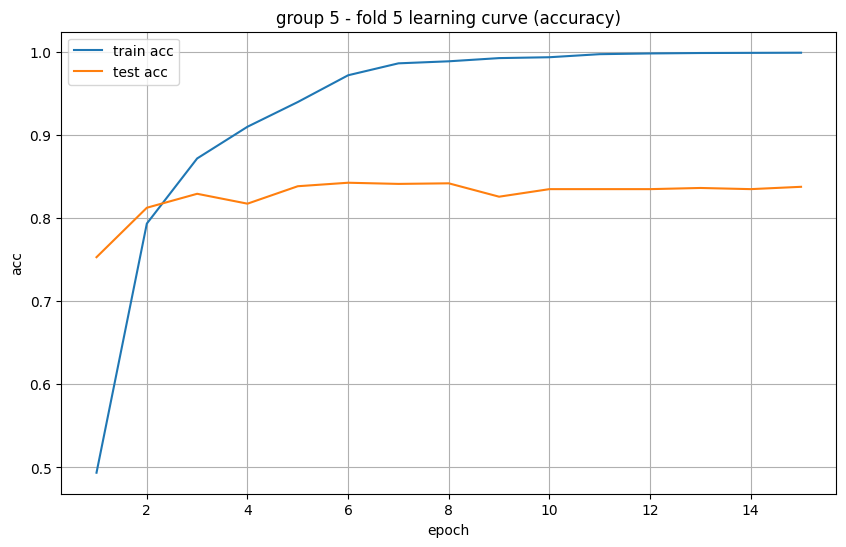

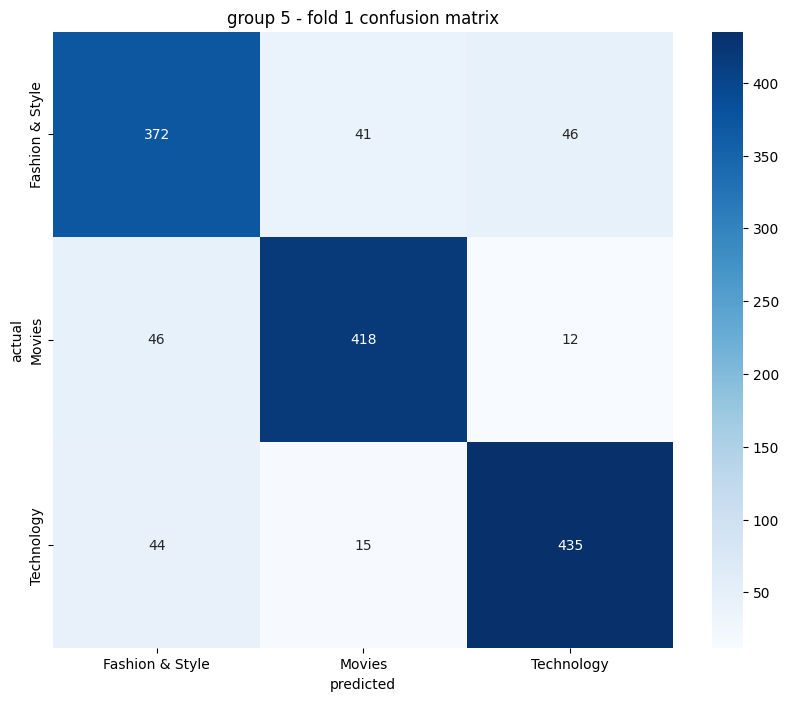

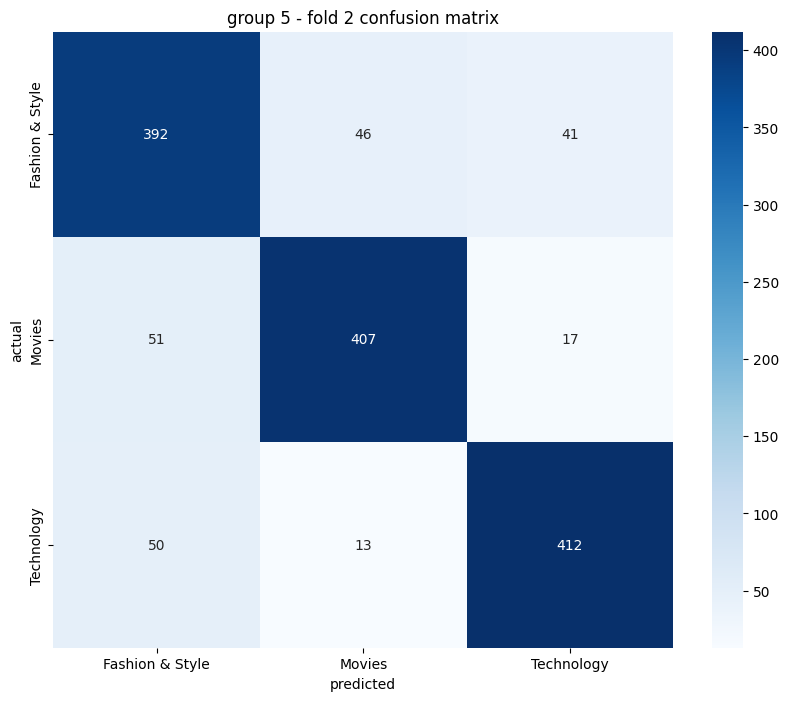

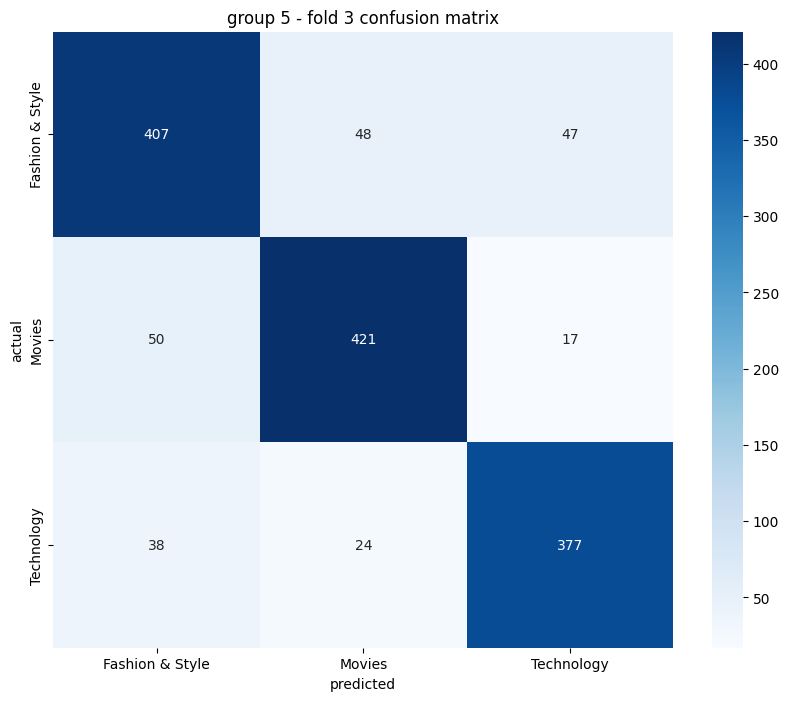

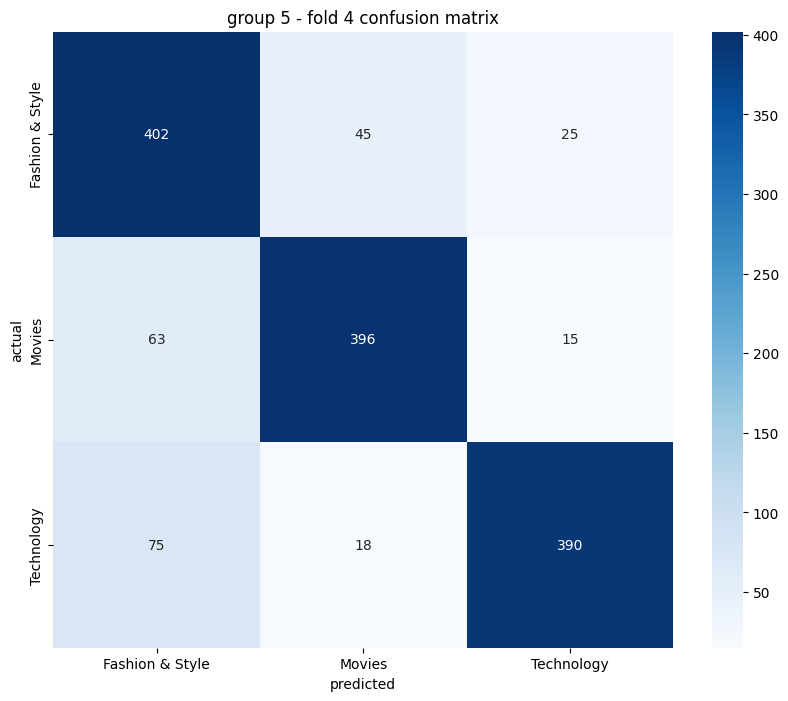

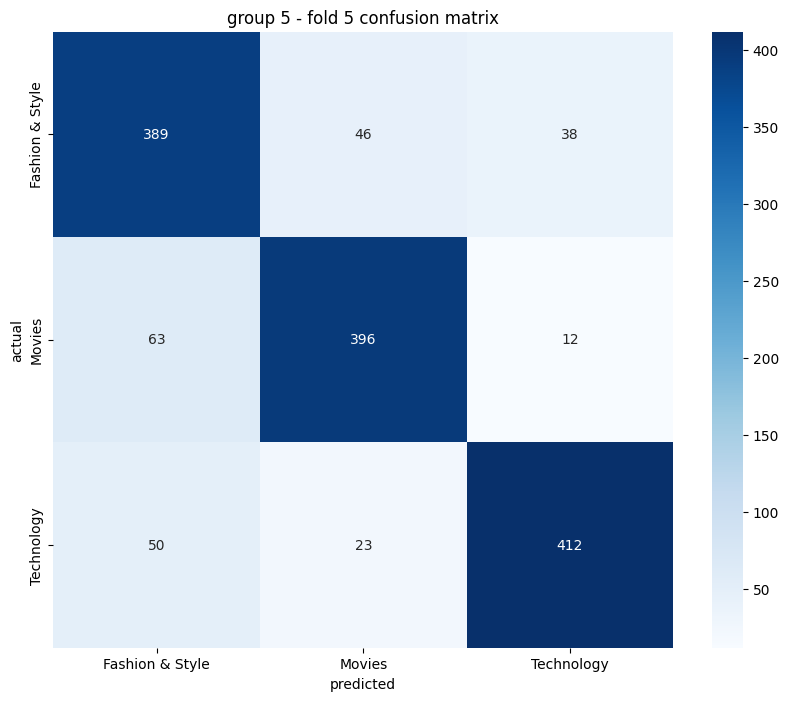


group 6 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 1.0504, train acc: 0.4420
                               test loss: 0.8977, test acc: 0.5789
    epoch 5/15: train loss: 0.3330, train acc: 0.8798
                               test loss: 0.6200, test acc: 0.7716
    epoch 10/15: train loss: 0.0656, train acc: 0.9820
                               test loss: 1.0624, test acc: 0.7585
    epoch 15/15: train loss: 0.0188, train acc: 0.9960
                               test loss: 1.3427, test acc: 0.7564

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.0188, train acc: 0.4513
                               test loss: 0.8128, test acc: 0.5629
    epoch 5/15: train loss: 0.3192, train acc: 0.8873
                               test loss: 0.6150, test acc: 0.7811
    epoch 10/15: train loss: 0.0788, train acc: 0.9778
                               test loss: 0.9296, test acc: 0.7745
    epoch 15/15: train loss: 0.0224, train acc: 0.9951
                               test lo

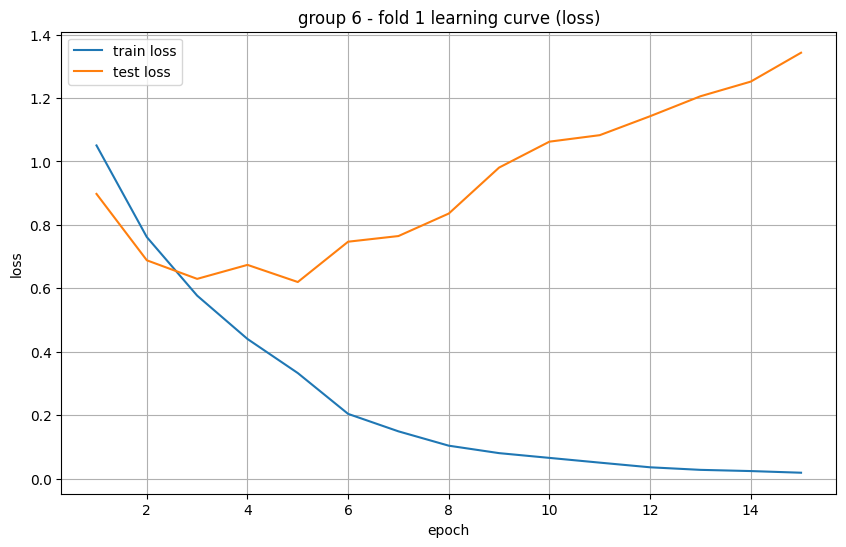

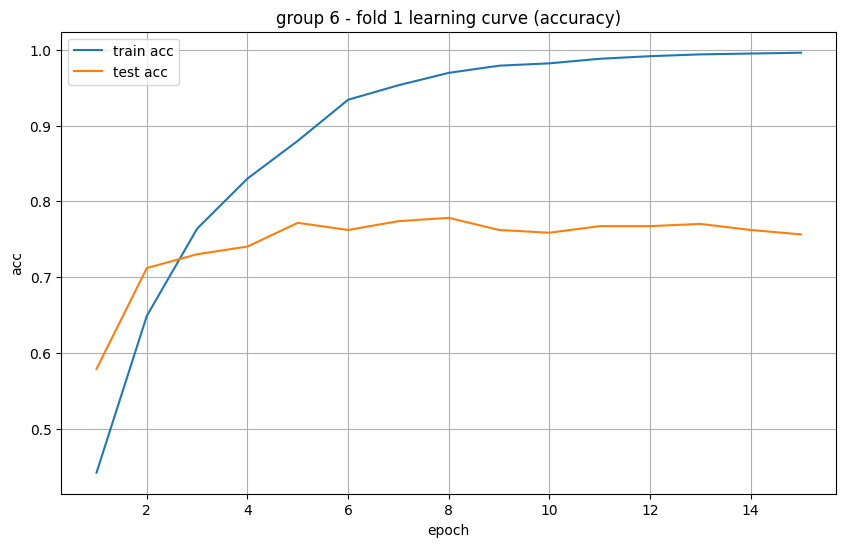

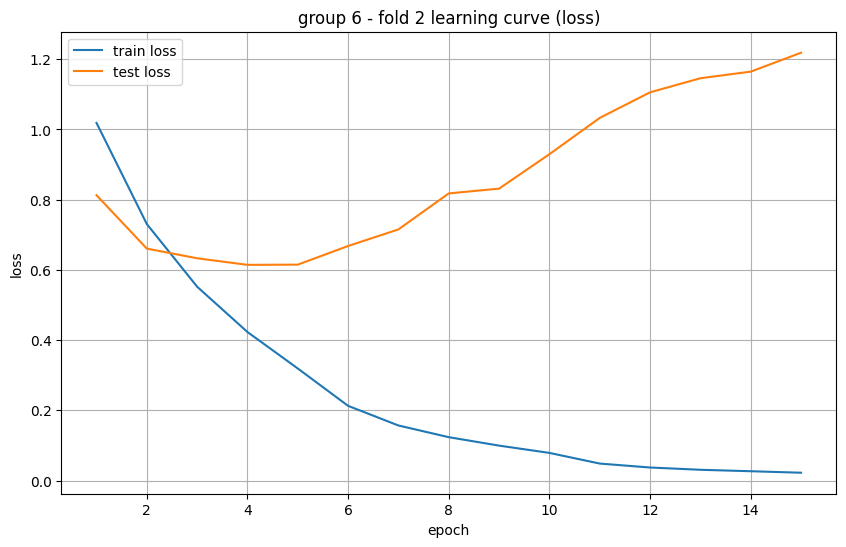

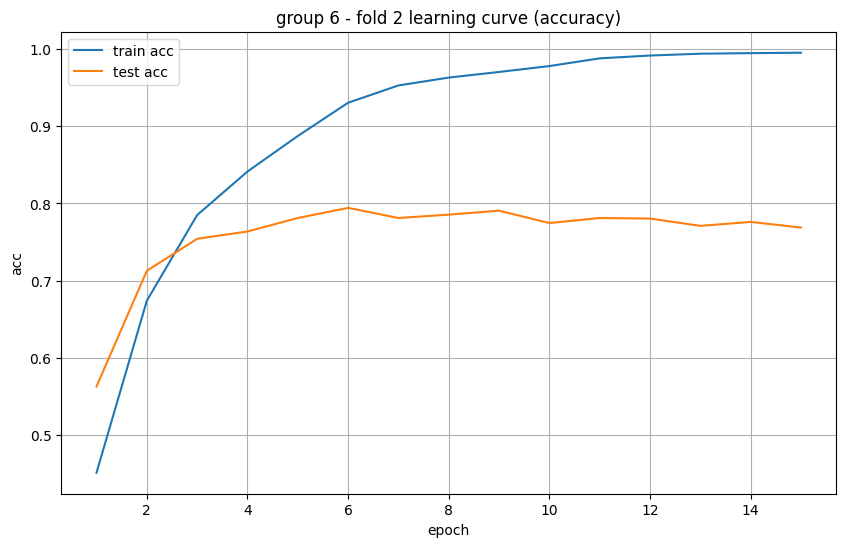

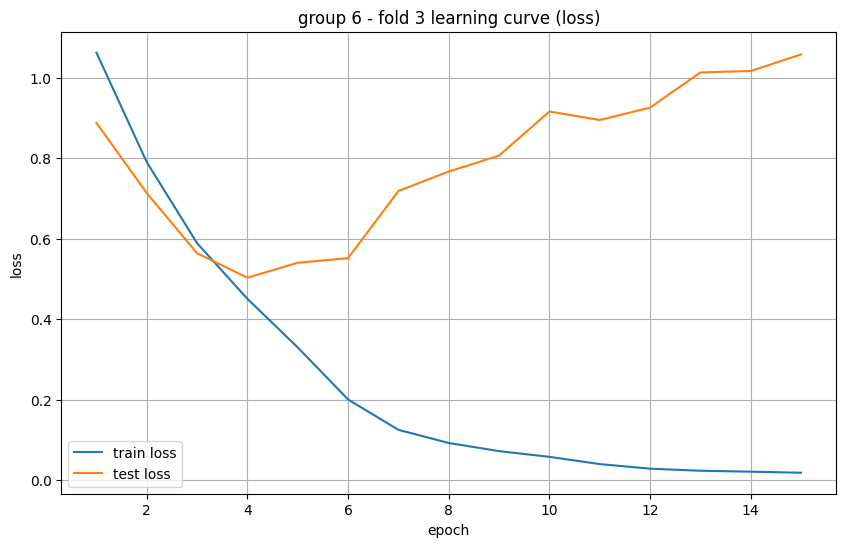

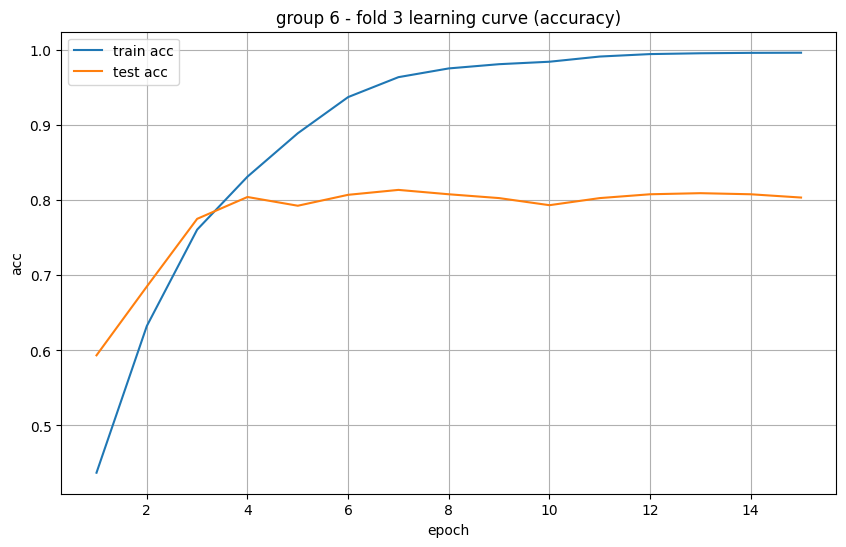

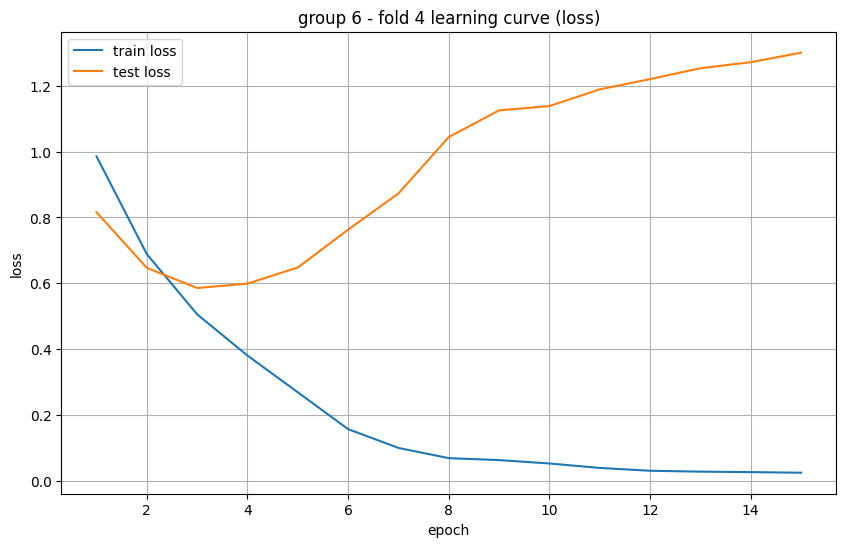

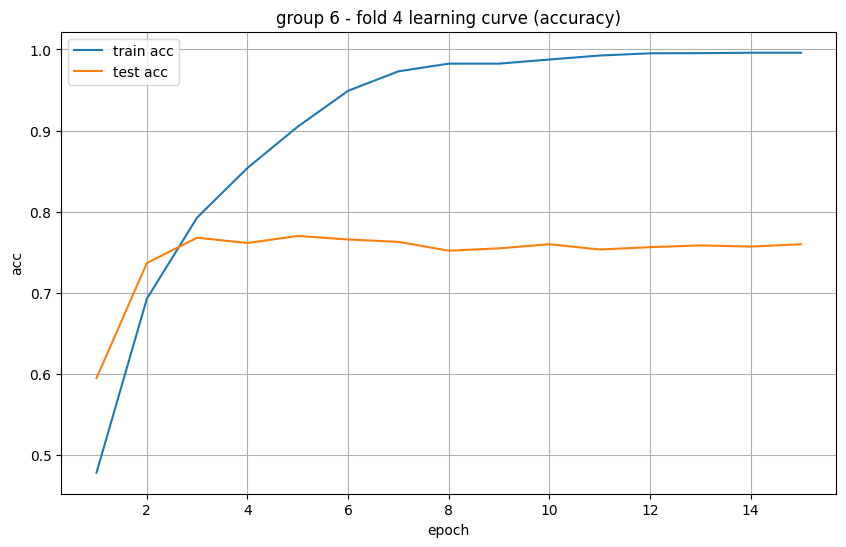

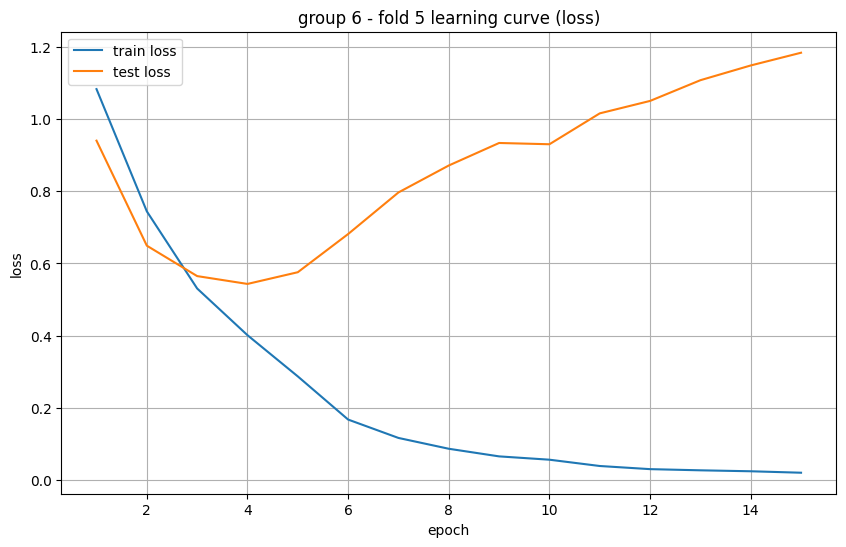

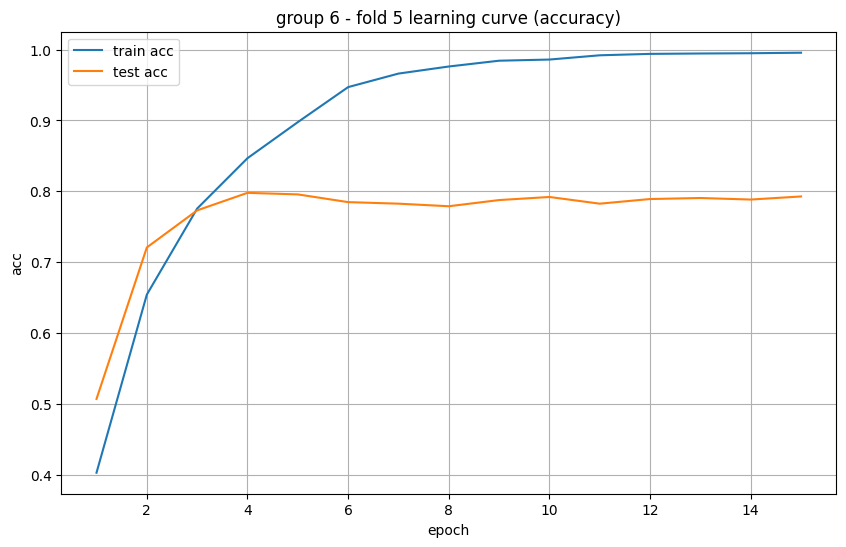

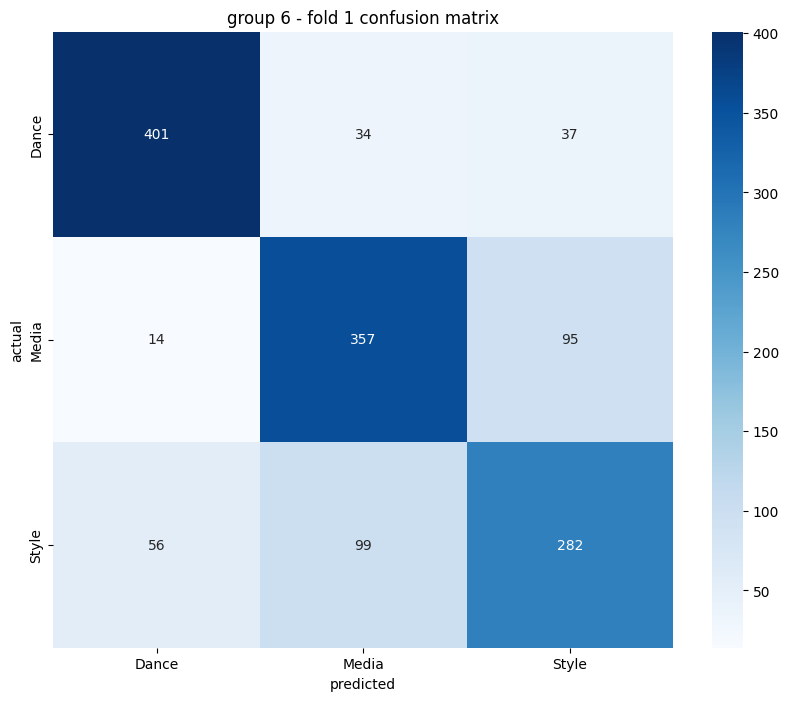

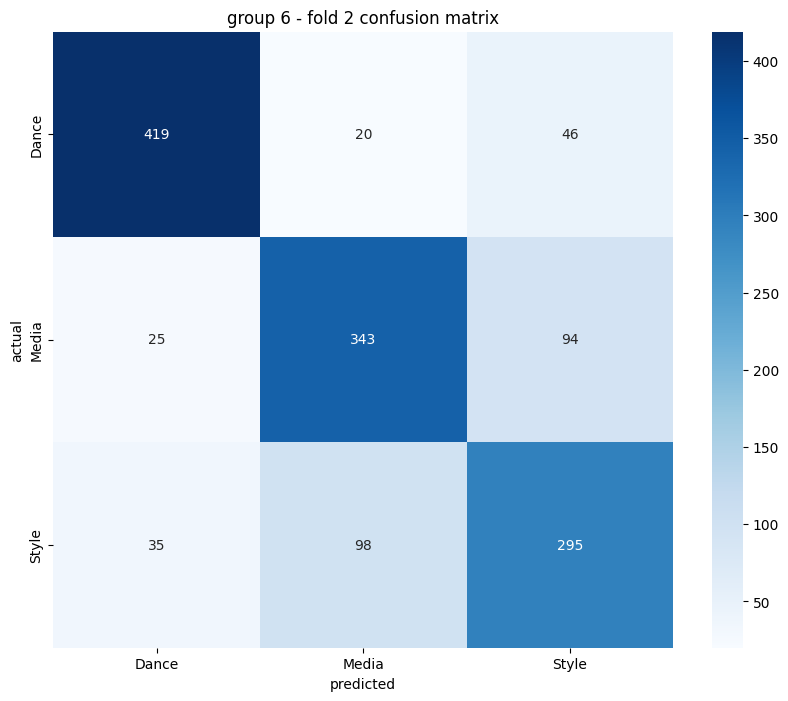

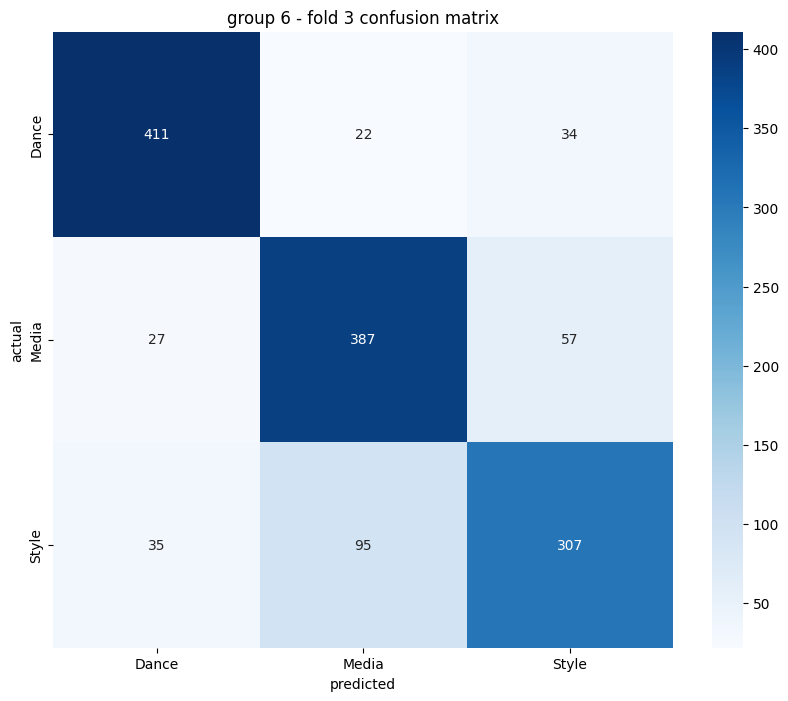

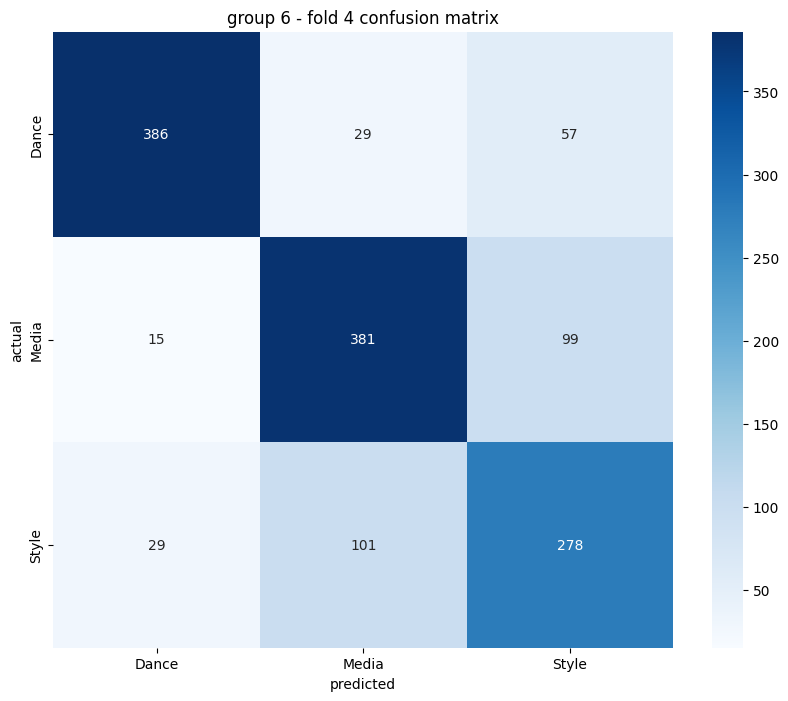

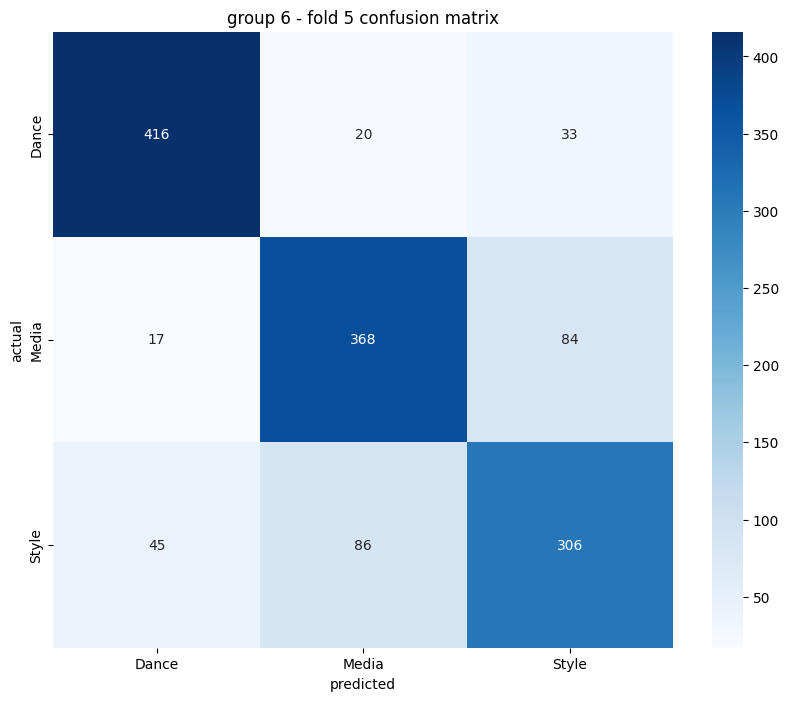


=== 모든 그룹의 요약 결과 ===

그룹 1 - 평균 테스트 정확도: 0.8324
  폴드 1: 테스트 정확도 = 0.8519
  폴드 2: 테스트 정확도 = 0.8320
  폴드 3: 테스트 정확도 = 0.8181
  폴드 4: 테스트 정확도 = 0.8394
  폴드 5: 테스트 정확도 = 0.8209

그룹 2 - 평균 테스트 정확도: 0.7991
  폴드 1: 테스트 정확도 = 0.8123
  폴드 2: 테스트 정확도 = 0.7971
  폴드 3: 테스트 정확도 = 0.8073
  폴드 4: 테스트 정확도 = 0.7921
  폴드 5: 테스트 정확도 = 0.7866

그룹 3 - 평균 테스트 정확도: 0.8398
  폴드 1: 테스트 정확도 = 0.8271
  폴드 2: 테스트 정확도 = 0.8347
  폴드 3: 테스트 정확도 = 0.8340
  폴드 4: 테스트 정확도 = 0.8568
  폴드 5: 테스트 정확도 = 0.8465

그룹 4 - 평균 테스트 정확도: 0.8635
  폴드 1: 테스트 정확도 = 0.8558
  폴드 2: 테스트 정확도 = 0.8670
  폴드 3: 테스트 정확도 = 0.8719
  폴드 4: 테스트 정확도 = 0.8524
  폴드 5: 테스트 정확도 = 0.8704

그룹 5 - 평균 테스트 정확도: 0.8434
  폴드 1: 테스트 정확도 = 0.8572
  폴드 2: 테스트 정확도 = 0.8474
  폴드 3: 테스트 정확도 = 0.8432
  폴드 4: 테스트 정확도 = 0.8314
  폴드 5: 테스트 정확도 = 0.8376

그룹 6 - 평균 테스트 정확도: 0.7763
  폴드 1: 테스트 정확도 = 0.7564
  폴드 2: 테스트 정확도 = 0.7687
  폴드 3: 테스트 정확도 = 0.8036
  폴드 4: 테스트 정확도 = 0.7600
  폴드 5: 테스트 정확도 = 0.7927


In [8]:
EPOCHS = 15
BATCH_SIZE = 32
K_FOLDS = 5
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
LATENT_SIZE = 64  # Latent의 수
NUM_BLOCKS = 4    # PerceiverBlock의 수

all_learning_curves = []
best_models = {} 

for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)

    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []
    best_fold_acc = 0.0
    best_model = None
    best_valid_loader = None

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  fold {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

        perceiver = Perceiver(
            input_dim=EMBED_DIM,
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        model = CombinedModel(
            vocab_size=VOCAB_SIZE,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)  
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            scheduler.step()

            current_lr = scheduler.get_last_lr()[0]
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'    epoch {epoch+1}/{EPOCHS}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
                print(f'                               test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
        if test_acc > best_fold_acc:
            best_fold_acc = test_acc
            best_model = model
            best_valid_loader = test_loader

        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                attention_mask_batch = batch['attention_mask'].to(device)  
                labels_batch = batch['labels'].to(device)

                outputs = model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })
    

    # 모델 및 데이터로더 저장장
    model_save_path = f"{model_path}/text_model_{idx}.pkl"
    torch.save(best_model, model_save_path)
    print(f"Group {idx} 최고 모델 저장 완료: {model_save_path}")

    val_loader_save_path = f"{loader_path}/text_val_loader_{idx}.pkl"
    with open(val_loader_save_path, 'wb') as f:
        pickle.dump(best_valid_loader, f) 
    print(f"Group {idx} 최고 valid loader 저장 완료: {val_loader_save_path}")
    
    
    # 결과 Analysis
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

  
    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    for fold_result in fold_results:
        print(f"\n  폴드 {fold_result['Fold']} 결과:")
        print(f"    테스트 정확도: {fold_result['Test Accuracy']:.4f}")
        print(pd.DataFrame(fold_result['Classification Report']).transpose())

    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="train loss")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="test loss")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (loss)")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(True)
        plt.show()

   
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="train acc")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="test acc")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (accuracy)")
        plt.xlabel("epoch")
        plt.ylabel("acc")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"group {idx} - fold {fold_idx} confusion matrix")
        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.show()

print("\n=== 모든 그룹의 요약 결과 ===")
for result in results:
    group_idx = result["Group"]
    avg_acc = result["Average Test Accuracy"]
    print(f"\n그룹 {group_idx} - 평균 테스트 정확도: {avg_acc:.4f}")
    for fold_result in result["Fold Results"]:
        fold_idx = fold_result["Fold"]
        fold_acc = fold_result["Test Accuracy"]
        print(f"  폴드 {fold_idx}: 테스트 정확도 = {fold_acc:.4f}")

In [4]:
import pickle

file_path = "/home/youlee/perceiver/perceiver/loader/text_val_loader_1.pkl"

with open(file_path, "rb") as file:
    data = pickle.load(file)

type_of_data = type(data)
if hasattr(data, 'shape'):
    data_shape = data.shape
else:
    try:
        data_shape = (len(data), len(data[0]))
    except Exception as e:
        data_shape = f"Cannot determine shape: {e}"

type_of_data, data_shape


(torch.utils.data.dataloader.DataLoader,
 "Cannot determine shape: 'DataLoader' object is not subscriptable")

In [19]:
for batch in data:
  
    if isinstance(batch, dict):
        print({key: value.shape for key, value in batch.items()})

    elif isinstance(batch, tuple):
        print(f"Inputs shape: {batch[0].shape}, Labels shape: {batch[1].shape}")
    else:
        print(f"Unknown batch format: {type(batch)}")
    break  

Inputs shape: torch.Size([196, 770]), Labels shape: torch.Size([])
